# Identifying fish

Showing that neural netwoks can distinguish between individuals in a population of fish. We will use miniCARP, a restricted version of a library of fish images prepared by the lab as part of __[idtracker.ai](http://idtracker.ai)__ paper.

In this notebook we show how neural networks can be used to classify between individuals in a population of fish. We will first show how MultiLayer Perceptrons (MLPs) can achieve decent accuracy at this task and then improve upon that accuracy by using Convolutional Neural Networks (CNNs).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import trange
from random import randint
import gdown

In [2]:
if torch.cuda.is_available():
    print("GPU is enabled.")
    DEVICE = "cuda"
else:
    print("WARNING: GPU is not enabled in this environment.")
    DEVICE = "cpu"

GPU is enabled.


We download the miniCARP dataset.

In [16]:
CARP_PATH = Path("./miniCARP/")


def download_carp():
    if not CARP_PATH.is_dir():
        CARP_PATH.mkdir()
        gdown.download(
            id="19u3X339wNDOYgTr4AZp-L8O_7F5I82Wp",
            output=str(CARP_PATH / "miniCARP_images.npy"),
        )
        gdown.download(
            id="1NeULdkj6HrPw8inKHJ4Sqhnts_6KDcik",
            output=str(CARP_PATH / "miniCARP_labels.npy"),
        )


def load_carp(fraction: float):
    download_carp()
    images: np.ndarray = np.load(CARP_PATH / "miniCARP_images.npy")
    labels: np.ndarray = np.load(CARP_PATH / "miniCARP_labels.npy")
    num_images = int(np.floor(images.shape[0] * fraction))
    return images[:num_images], labels[:num_images]


all_images, all_labels = load_carp(fraction=0.1)

Let's get some information about the dataset.

In [18]:
print(f"Images shape: {all_images.shape}, dtype: {all_images.dtype}")
print(f"Labels shape: {all_labels.shape}, dtype: {all_labels.dtype}")
print(f"Label options: {set(all_labels)}")
NUM_LABELS = len(set(all_labels))

Images shape: (7500, 52, 52), dtype: uint8
Labels shape: (7500,), dtype: uint8
Label options: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


We loaded 7500 images of size 52x52 corresponding to 15 different individuals, numbered 0-14. Here, we print some examples, together with the labels. Feel free to change the range of images and labels to be shown.

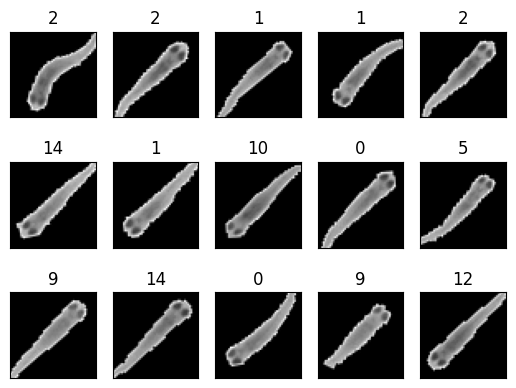

In [22]:
def show_images(images, labels=None):
    fig, axes = plt.subplots(3, len(images) // 3)
    for image, ax in zip(images, axes.flatten()):
        ax.imshow(image, cmap="binary_r")
        ax.set(xticks=(), yticks=())
    if labels is not None:
        for label, ax in zip(labels, axes.flatten()):
            ax.set(title=label)
    plt.show()


# Change range here to print other images
index = randint(0, len(all_images) - 15)
show_images(all_images[index : index + 15], labels=all_labels[index : index + 15])

We divide the dataset into disjoint train/validation/test datasets.

In [23]:
VALIDATION_FRAMES = 1000
TEST_FRAMES = 1000


def partition_data(
    data: np.ndarray, validation: int = VALIDATION_FRAMES, test: int = TEST_FRAMES
):
    assert validation + test < len(data)
    return {
        "train": torch.tensor(data[validation:-test]),
        "validation": torch.tensor(data[:validation]),
        "test": torch.tensor(data[-test:]),
    }


labels = partition_data(all_labels)
images = partition_data(all_images)

print(
    "Validation and test are fractions {:.2%} and {:.2%}".format(
        images["validation"].shape[0] / all_images.shape[0],
        images["test"].shape[0] / all_images.shape[0],
    )
)

Validation and test are fractions 13.33% and 13.33%


We now normalise the images to have mean 0 and standard deviation 1, using only the train data to compute the mean and standard deviation.

In [24]:
keywords = ["train", "validation", "test"]
images_train_mean, images_train_std = (
    images["train"].float().mean(),
    images["train"].float().std(),
)

for keyword in keywords:
    images[keyword] = (images[keyword] - images_train_mean) / images_train_std

print(
    f"New range for train set: {images['train'].min():.4f} to"
    f" {images['train'].max():.4f}"
)

New range for train set: -0.4970 to 4.0826


We use the TensorDataset to create a dataset from the two tensors of images and labels. We will then be able to use those datasets as dataloaders.

In [25]:
train_dataset = TensorDataset((images["train"]).unsqueeze(1), labels["train"])
validation_dataset = TensorDataset(
    (images["validation"]).unsqueeze(1), labels["validation"]
)
test_dataset = TensorDataset((images["test"]).unsqueeze(1), labels["test"])

train_dataloader = DataLoader(train_dataset, batch_size=128)
validation_dataloader = DataLoader(validation_dataset, batch_size=128)
test_dataloader = DataLoader(test_dataset, batch_size=128)

We begin with the MLP. This network is prepared to accept a list of sizes for the hidden layers and initialize itself properly. The default values can be changed on call.

In [26]:
class CARPLinearNetwork(nn.Module):
    def __init__(
        self,
        input_shape=52 * 52,
        hiden_layer_sizes=[512, 512, 512],
        number_outputs=NUM_LABELS,
    ):
        super().__init__()
        layer_sizes = [input_shape] + hiden_layer_sizes + [number_outputs]

        self.layers = nn.Sequential(nn.Flatten())

        for i in range(len(layer_sizes) - 2):
            self.layers.add_module(
                f"Linear_{i}",
                nn.Linear(in_features=layer_sizes[i], out_features=layer_sizes[i + 1]),
            )
            self.layers.add_module(f"ReLU_{i}", nn.ReLU())

        self.layers.add_module(
            "Last", nn.Linear(in_features=layer_sizes[-2], out_features=layer_sizes[-1])
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

Thus, the network we use consist on three hidden dense layers, using ReLU as non-linearity, together with a final output layer. We will train it using Cross-Entropy loss.

In [27]:
carp_linear = CARPLinearNetwork().to(DEVICE)
optimizer = torch.optim.Adam(carp_linear.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
print(carp_linear)
print(sum(p.numel() for p in carp_linear.parameters()) / 1.0e6, "M parameters")

CARPLinearNetwork(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (Linear_0): Linear(in_features=2704, out_features=512, bias=True)
    (ReLU_0): ReLU()
    (Linear_1): Linear(in_features=512, out_features=512, bias=True)
    (ReLU_1): ReLU()
    (Linear_2): Linear(in_features=512, out_features=512, bias=True)
    (ReLU_2): ReLU()
    (Last): Linear(in_features=512, out_features=15, bias=True)
  )
)
1.917967 M parameters


In [28]:
def train_loop(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    validation_loader: DataLoader,
    loss_fn: nn.Module,
    device: str,
    epochs: int = 150,
):
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    for _ in trange(epochs, desc="Training"):
        running_loss = 0.0
        correct, total = 0, 0

        model.train()
        # Train on a batch of images
        for images, labels in train_loader:
            output = model(images.to(device))
            optimizer.zero_grad()
            loss = loss_fn(output, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # get accuracy
            _, predicted = torch.max(output, dim=1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

        # append the loss for this epoch (running loss divided by
        # the number of batches e.g. len(train_loader))
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        # Loss and accuracy for validation dataset
        for images, labels in validation_loader:
            output = model(images.to(device))
            loss = loss_fn(output, labels.to(device))

            running_loss += loss.item()

            _, predicted = torch.max(output, dim=1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

        # append the loss for this epoch (running loss divided by
        # the number of batches e.g. len(train_loader))
        val_loss.append(running_loss / len(train_loader))
        val_acc.append(correct / total)

    return train_loss, train_acc, val_loss, val_acc

Let's train!

In [29]:
train_loss, train_acc, val_loss, val_acc = train_loop(
    carp_linear,
    optimizer=optimizer,
    train_loader=train_dataloader,
    validation_loader=validation_dataloader,
    loss_fn=loss_fn,
    device=DEVICE,
)

Training:   0%|          | 0/150 [00:00<?, ?it/s]

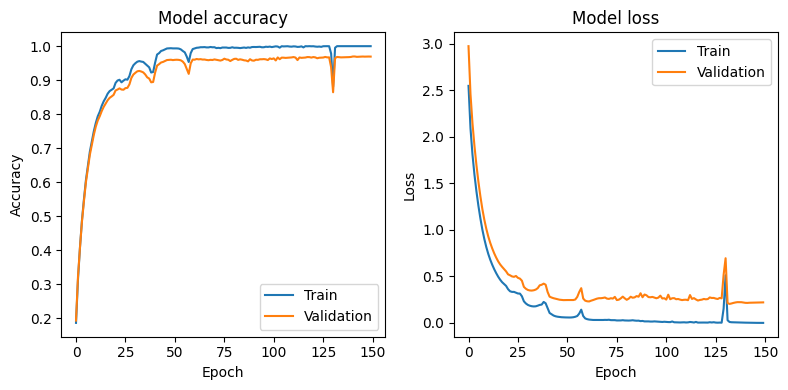

In [30]:
fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(8, 4))
ax_acc.plot(train_acc, label="Train")
ax_acc.plot(val_acc, label="Validation")
ax_acc.set(title="Model accuracy", ylabel="Accuracy", xlabel="Epoch")
ax_acc.legend()

ax_loss.plot(train_loss, label="Train")
ax_loss.plot(val_loss, label="Validation")
ax_loss.set(title="Model loss", ylabel="Loss", xlabel="Epoch")
ax_loss.legend()
plt.tight_layout()

We observe how the network achieves accuracies close to 90% on validation. What about the test set?

In [31]:
def test(model: nn.Module, data_loader: DataLoader, device: str):
    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total


accuracy = test(carp_linear, test_dataloader, DEVICE)
print(f"The model has a test accuracy of {accuracy:.2%}")

The model has a test accuracy of 80.70%


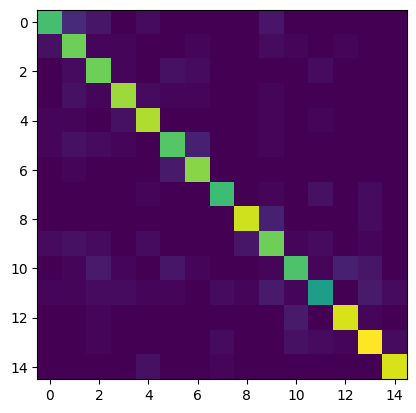

In [32]:
from sklearn.metrics import confusion_matrix


def network_confusion_matrix(model: nn.Module, data_loader: DataLoader, device: str):
    model.eval()
    predictions = torch.tensor([]).to(device)
    true_values = torch.tensor([]).to(device)

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)

        predictions = torch.cat((predictions, predicted), 0)
        true_values = torch.cat((true_values, labels), 0)

    confusion = confusion_matrix(true_values.cpu(), predictions.cpu())
    plt.imshow(confusion, interpolation="none")
    plt.show()


network_confusion_matrix(carp_linear, test_dataloader, DEVICE)

Thus, this very simple network is already able to classify this population of fish with a decent level of accuracy. However, MLPs are not the most adequate networks to work with images, as they do not include the proper biases for these kinds of data.

Let us now move to using Convolutional Neural Networks (CNN), which are able to take into consideration local information and also extract features from images that are invariant to small translations and rotations, thus being much more suited to use with images.

In [33]:
from typing import Sequence


class CNN(nn.Module):
    """
    This is the CNN idtrackerai uses for crossing detection and identification.
    I could be loaded from it:
        from idtrackerai.network import CNN
    """

    def __init__(self, input_shape: Sequence[int], out_dim: int):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(input_shape[-1], 16, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 64, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 100, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(100 * (input_shape[1] // 4) ** 2, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, out_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

Again, we use Cross-Entroy loss.

In [34]:
carp_conv = CNN((52, 52, 1), 15).to(DEVICE)
optimizer = torch.optim.Adam(params=carp_conv.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

print(carp_conv)
print(sum(p.numel() for p in carp_conv.parameters()) / 1.0e6, "M parameters")

CNN(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=16900, out_features=100, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=100, out_features=15, bias=True)
  )
)
1.877795 M parameters


In [35]:
train_loss, train_acc, val_loss, val_acc = train_loop(
    carp_conv,
    optimizer=optimizer,
    train_loader=train_dataloader,
    validation_loader=validation_dataloader,
    loss_fn=loss_fn,
    device=DEVICE,
)

Training:   0%|          | 0/150 [00:00<?, ?it/s]

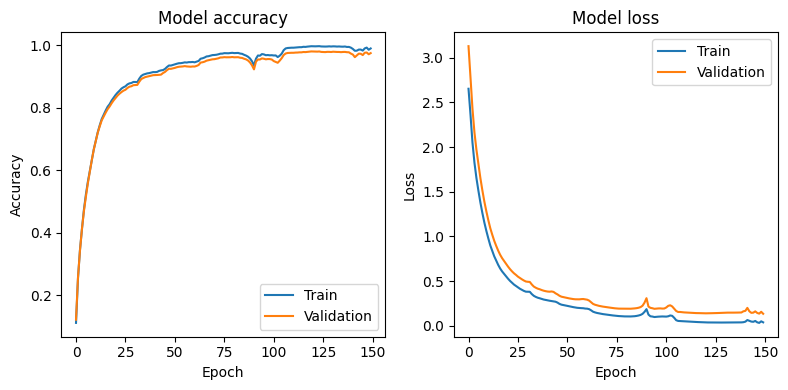

In [36]:
fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(8, 4))
ax_acc.plot(train_acc, label="Train")
ax_acc.plot(val_acc, label="Validation")
ax_acc.set(title="Model accuracy", ylabel="Accuracy", xlabel="Epoch")
ax_acc.legend()

ax_loss.plot(train_loss, label="Train")
ax_loss.plot(val_loss, label="Validation")
ax_loss.set(title="Model loss", ylabel="Loss", xlabel="Epoch")
ax_loss.legend()
plt.tight_layout()

Validation accuracy is now much closer to training and over 90%. What about test set accuracy?

In [37]:
accuracy = test(carp_conv, test_dataloader, DEVICE)
print(f"The model has a test accuracy of {accuracy:.2%}")

The model has a test accuracy of 91.90%


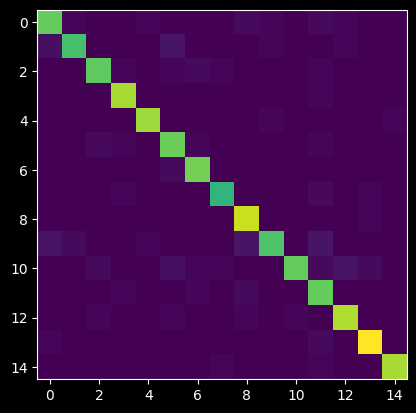

In [38]:
network_confusion_matrix(carp_conv, test_dataloader, DEVICE)

We see a significantly higher accuracy on the test data when using a CNN. This exhibits that even small CNNs that don't take long to train can be quite successful at classifying individuals from a population of fish with great accuracy.